In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from textblob import TextBlob

# Data Collection

In [3]:
tweet= pd.read_csv("Tweets.csv")
tweet.head()

tweet_id airline_sentiment negativereason         airline  \
0  5.703060e+17           neutral            NaN  Virgin America   
1  5.703010e+17          positive            NaN  Virgin America   
2  5.703010e+17           neutral            NaN  Virgin America   
3  5.703010e+17          negative     Bad Flight  Virgin America   
4  5.703010e+17          negative     Can't Tell  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

     tweet_created tweet_location               user_timezone  
0  2/24/2015 11:35            NaN  Eastern Time (US & Canada)  
1  2/24/2015 11:15            NaN  Pacific Time (US & Canada)  
2  2/24/2015 11:15      Lets Play  Central Time (US & Canada)  
3  2/24/2015 11:15            NaN  Pacific Time (US & Canada)  
4  2/24/2015 11:14            NaN  Pacific Time (US & Canada)

In [4]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 13 columns):
tweet_id                  14640 non-null float64
airline_sentiment         14640 non-null object
negativereason            9178 non-null object
airline                   14640 non-null object
airline_sentiment_gold    40 non-null object
name                      14640 non-null object
negativereason_gold       32 non-null object
retweet_count             14640 non-null int64
text                      14640 non-null object
tweet_coord               1019 non-null object
tweet_created             14640 non-null object
tweet_location            9907 non-null object
user_timezone             9820 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 1.5+ MB


In [5]:
tweet.shape

(14640, 13)

In [6]:
tweet.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [7]:
tweet['airline_sentiment'].isnull().any()

False

In [8]:
tweet['airline'].isnull().any()

False

In [9]:
tweet['tweet_created'].isnull().any()

False

In [10]:
tweet['user_timezone'].isnull().any()

True

In [11]:
F1NullCheck = tweet['negativereason'].isnull().value_counts()
F2NullCheck = tweet['airline_sentiment_gold'].isnull().value_counts()
F3NullCheck = tweet['negativereason_gold'].isnull().value_counts()
F4NullCheck = tweet['tweet_coord'].isnull().value_counts()
F5NullCheck = tweet['tweet_location'].isnull().value_counts()
F6NullCheck = tweet['user_timezone'].isnull().value_counts()

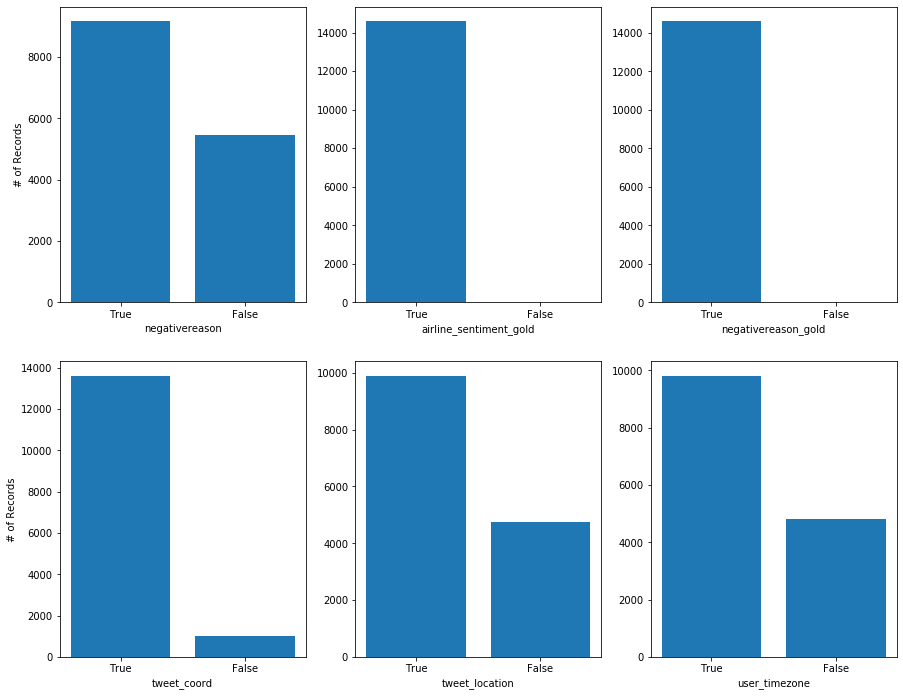

In [12]:
Index = [1,2]
IndexValues = ['True','False']
plt.figure(figsize=(15,25))
#
plt.subplot(4,3,1)
plt.bar(Index,F1NullCheck)
plt.xticks(Index,IndexValues)
plt.ylabel('# of Records')
plt.xlabel('negativereason')
#
plt.subplot(4,3,2)
plt.bar(Index,F2NullCheck)
plt.xticks(Index,IndexValues)
plt.xlabel('airline_sentiment_gold')
#
plt.subplot(4,3,3)
plt.bar(Index,F3NullCheck)
plt.xticks(Index,IndexValues)
plt.xlabel('negativereason_gold')
#
plt.subplot(4,3,4)
plt.bar(Index,F4NullCheck)
plt.xticks(Index,IndexValues)
plt.xlabel('tweet_coord')
plt.ylabel('# of Records')
#
plt.subplot(4,3,5)
plt.bar(Index,F5NullCheck)
plt.xticks(Index,IndexValues)
plt.xlabel('tweet_location')
#
plt.subplot(4,3,6)
plt.bar(Index,F6NullCheck)
plt.xticks(Index,IndexValues)
plt.xlabel('user_timezone')
#
plt.show()

# Feature Engineering

In [13]:
tweet = tweet.drop(['airline_sentiment_gold','negativereason_gold','tweet_coord', 'user_timezone', 'tweet_location', 'tweet_created'], axis=1)

In [14]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 7 columns):
tweet_id             14640 non-null float64
airline_sentiment    14640 non-null object
negativereason       9178 non-null object
airline              14640 non-null object
name                 14640 non-null object
retweet_count        14640 non-null int64
text                 14640 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 800.8+ KB


Text(0.5, 1.0, 'Count of Each Airline Tweets')

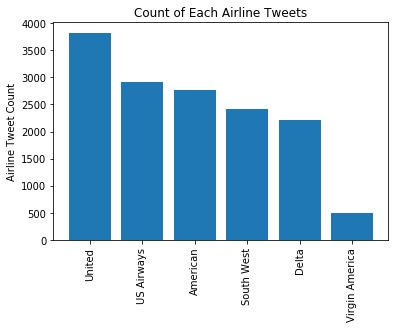

In [15]:
Group_Count=tweet['airline'].value_counts()
Index = [1,2,3,4,5,6]
plt.bar(Index,Group_Count)
plt.xticks(Index,['United','US Airways','American','South West','Delta','Virgin America'],rotation=90)
plt.ylabel('Airline Tweet Count')
plt.title('Count of Each Airline Tweets')

Text(0.5, 1.0, 'Count of Sentiment')

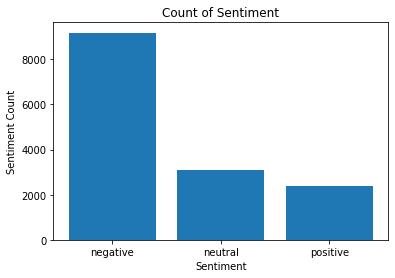

In [16]:
Sentiment_count=tweet['airline_sentiment'].value_counts()
Index = [1,2,3]
plt.bar(Index,Sentiment_count)
plt.xticks(Index,['negative','neutral','positive'])
plt.ylabel('Sentiment Count')
plt.xlabel('Sentiment')
plt.title('Count of Sentiment')

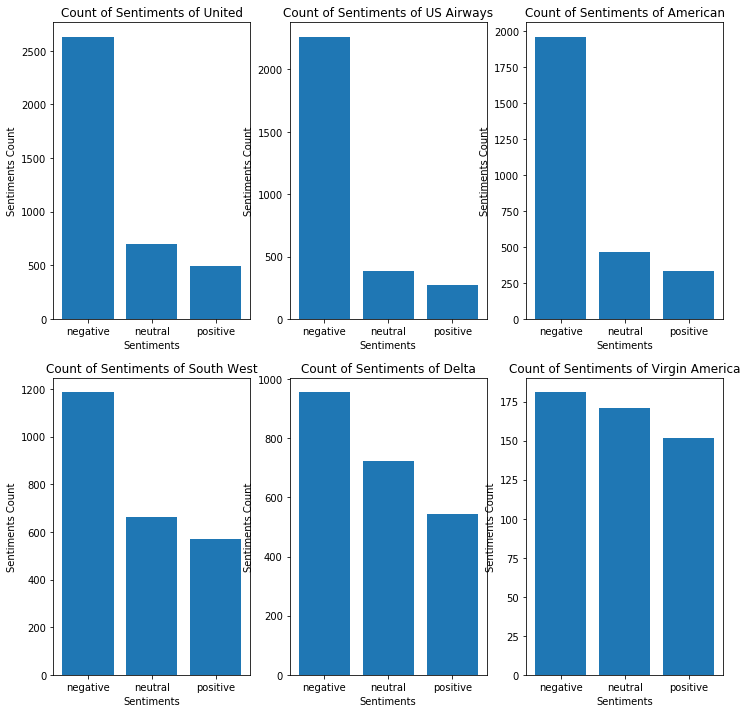

In [17]:
plt.figure(1,figsize=(12, 12))
#
plt.subplot(2,3,1)
df=tweet[tweet['airline']=='United']
count=df['airline_sentiment'].value_counts()
Index = [1,2,3]
plt.bar(Index,count)
plt.xticks(Index,['negative','neutral','positive'])
plt.ylabel('Sentiments Count')
plt.xlabel('Sentiments')
plt.title('Count of Sentiments of United')
#
plt.subplot(2,3,2)
df=tweet[tweet['airline']=='US Airways']
count=df['airline_sentiment'].value_counts()
plt.bar(Index,count)
plt.xticks(Index,['negative','neutral','positive'])
plt.ylabel('Sentiments Count')
plt.xlabel('Sentiments')
plt.title('Count of Sentiments of US Airways')
#
plt.subplot(2,3,3)
df=tweet[tweet['airline']=='American']
count=df['airline_sentiment'].value_counts()
plt.bar(Index,count)
plt.xticks(Index,['negative','neutral','positive'])
plt.ylabel('Sentiments Count')
plt.xlabel('Sentiments')
plt.title('Count of Sentiments of American')
#
plt.subplot(2,3,4)
df=tweet[tweet['airline']=='Southwest']
count=df['airline_sentiment'].value_counts()
plt.bar(Index,count)
plt.xticks(Index,['negative','neutral','positive'])
plt.ylabel('Sentiments Count')
plt.xlabel('Sentiments')
plt.title('Count of Sentiments of South West')
#
plt.subplot(2,3,5)
df=tweet[tweet['airline']=='Delta']
count=df['airline_sentiment'].value_counts()
plt.bar(Index,count)
plt.xticks(Index,['negative','neutral','positive'])
plt.ylabel('Sentiments Count')
plt.xlabel('Sentiments')
plt.title('Count of Sentiments of Delta')
#
plt.subplot(2,3,6)
df=tweet[tweet['airline']=='Virgin America']
count=df['airline_sentiment'].value_counts()
plt.bar(Index,count)
plt.xticks(Index,['negative','neutral','positive'])
plt.ylabel('Sentiments Count')
plt.xlabel('Sentiments')
plt.title('Count of Sentiments of Virgin America')
#
plt.show()

In [18]:
print('unique words: ', len(tweet['text'].str.split(' ', expand=True).stack().unique()))

unique words:  30165


In [19]:
tweet = tweet.drop(['retweet_count', 'negativereason'], axis=1)
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 5 columns):
tweet_id             14640 non-null float64
airline_sentiment    14640 non-null object
airline              14640 non-null object
name                 14640 non-null object
text                 14640 non-null object
dtypes: float64(1), object(4)
memory usage: 572.0+ KB


In [20]:
tweet.head()

tweet_id airline_sentiment         airline        name  \
0  5.703060e+17           neutral  Virgin America     cairdin   
1  5.703010e+17          positive  Virgin America    jnardino   
2  5.703010e+17           neutral  Virgin America  yvonnalynn   
3  5.703010e+17          negative  Virgin America    jnardino   
4  5.703010e+17          negative  Virgin America    jnardino   

                                                text  
0                @VirginAmerica What @dhepburn said.  
1  @VirginAmerica plus you've added commercials t...  
2  @VirginAmerica I didn't today... Must mean I n...  
3  @VirginAmerica it's really aggressive to blast...  
4  @VirginAmerica and it's a really big bad thing...

In [21]:
tweet = tweet.drop(['tweet_id','name'], axis=1)
tweet.head()

airline_sentiment         airline  \
0           neutral  Virgin America   
1          positive  Virgin America   
2           neutral  Virgin America   
3          negative  Virgin America   
4          negative  Virgin America   

                                                text  
0                @VirginAmerica What @dhepburn said.  
1  @VirginAmerica plus you've added commercials t...  
2  @VirginAmerica I didn't today... Must mean I n...  
3  @VirginAmerica it's really aggressive to blast...  
4  @VirginAmerica and it's a really big bad thing...

In [22]:
tweet['sentiment']=tweet.airline_sentiment.map({'negative': -1, 'neutral': 0, 'positive': 1 })
tweet.sentiment.head()

0    0
1    1
2    0
3   -1
4   -1
Name: sentiment, dtype: int64

In [23]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 4 columns):
airline_sentiment    14640 non-null object
airline              14640 non-null object
text                 14640 non-null object
sentiment            14640 non-null int64
dtypes: int64(1), object(3)
memory usage: 457.6+ KB


In [24]:
tweet['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [25]:
tweet['sentiment'].value_counts()

-1    9178
 0    3099
 1    2363
Name: sentiment, dtype: int64

# Cleaning Tweets

In [26]:
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [27]:
tweet['clean_tweet']=tweet['text'].apply(lambda x: clean_tweet(x))

In [28]:
tweet.head()

airline_sentiment         airline  \
0           neutral  Virgin America   
1          positive  Virgin America   
2           neutral  Virgin America   
3          negative  Virgin America   
4          negative  Virgin America   

                                                text  sentiment  \
0                @VirginAmerica What @dhepburn said.          0   
1  @VirginAmerica plus you've added commercials t...          1   
2  @VirginAmerica I didn't today... Must mean I n...          0   
3  @VirginAmerica it's really aggressive to blast...         -1   
4  @VirginAmerica and it's a really big bad thing...         -1   

                                         clean_tweet  
0                                          What said  
1  plus you ve added commercials to the experienc...  
2  I didn t today Must mean I need to take anothe...  
3  it s really aggressive to blast obnoxious ente...  
4           and it s a really big bad thing about it

In [29]:
def tweet_to_words(clean_tweet):
    no_puc=''.join([c for c in clean_tweet if c not in string.punctuation])
    words = no_puc.lower().split()                             
    stops = set(stopwords.words("english"))         
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

In [30]:
tweet['processed_tweet']=tweet['clean_tweet'].apply(lambda x: tweet_to_words(x))

In [31]:
tweet.head()

airline_sentiment         airline  \
0           neutral  Virgin America   
1          positive  Virgin America   
2           neutral  Virgin America   
3          negative  Virgin America   
4          negative  Virgin America   

                                                text  sentiment  \
0                @VirginAmerica What @dhepburn said.          0   
1  @VirginAmerica plus you've added commercials t...          1   
2  @VirginAmerica I didn't today... Must mean I n...          0   
3  @VirginAmerica it's really aggressive to blast...         -1   
4  @VirginAmerica and it's a really big bad thing...         -1   

                                         clean_tweet  \
0                                          What said   
1  plus you ve added commercials to the experienc...   
2  I didn t today Must mean I need to take anothe...   
3  it s really aggressive to blast obnoxious ente...   
4           and it s a really big bad thing about it   

                                     processed_tweet  
0                                               said  
1            plus added commercials experience tacky  
2             today must mean need take another trip  
3  really aggressive blast obnoxious entertainmen...  
4                               really big bad thing

In [32]:
lemmatizer=WordNetLemmatizer()
def word_lemmatizer(text):
    lem_text = ' '.join([lemmatizer.lemmatize(i, pos='v') for i in text.split(' ')])
    return lem_text

In [33]:
tweet['processed_tweet_lem'] =tweet.processed_tweet.apply(lambda x: word_lemmatizer(x))
tweet.head(10)

airline_sentiment         airline  \
0           neutral  Virgin America   
1          positive  Virgin America   
2           neutral  Virgin America   
3          negative  Virgin America   
4          negative  Virgin America   
5          negative  Virgin America   
6          positive  Virgin America   
7           neutral  Virgin America   
8          positive  Virgin America   
9          positive  Virgin America   

                                                text  sentiment  \
0                @VirginAmerica What @dhepburn said.          0   
1  @VirginAmerica plus you've added commercials t...          1   
2  @VirginAmerica I didn't today... Must mean I n...          0   
3  @VirginAmerica it's really aggressive to blast...         -1   
4  @VirginAmerica and it's a really big bad thing...         -1   
5  @VirginAmerica seriously would pay $30 a fligh...         -1   
6  @VirginAmerica yes, nearly every time I fly VX...          1   
7  @VirginAmerica Really missed a prime opportuni...          0   
8    @virginamerica Well, I didn't…but NOW I DO! :-D          1   
9  @VirginAmerica it was amazing, and arrived an ...          1   

                                         clean_tweet  \
0                                          What said   
1  plus you ve added commercials to the experienc...   
2  I didn t today Must mean I need to take anothe...   
3  it s really aggressive to blast obnoxious ente...   
4           and it s a really big bad thing about it   
5  seriously would pay 30 a flight for seats that...   
6  yes nearly every time I fly VX this ear worm w...   
7  Really missed a prime opportunity for Men With...   
8                       Well I didn t but NOW I DO D   
9  it was amazing and arrived an hour early You r...   

                                     processed_tweet  \
0                                               said   
1            plus added commercials experience tacky   
2             today must mean need take another trip   
3  really aggressive blast obnoxious entertainmen...   
4                               really big bad thing   
5  seriously would pay 30 flight seats playing re...   
6      yes nearly every time fly vx ear worm go away   
7  really missed prime opportunity men without ha...   
8                                               well   
9                    amazing arrived hour early good   

                                 processed_tweet_lem  
0                                                say  
1              plus add commercials experience tacky  
2             today must mean need take another trip  
3  really aggressive blast obnoxious entertainmen...  
4                               really big bad thing  
5  seriously would pay 30 flight seat play really...  
6      yes nearly every time fly vx ear worm go away  
7  really miss prime opportunity men without hat ...  
8                                               well  
9                       amaze arrive hour early good

In [34]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 7 columns):
airline_sentiment      14640 non-null object
airline                14640 non-null object
text                   14640 non-null object
sentiment              14640 non-null int64
clean_tweet            14640 non-null object
processed_tweet        14640 non-null object
processed_tweet_lem    14640 non-null object
dtypes: int64(1), object(6)
memory usage: 800.8+ KB


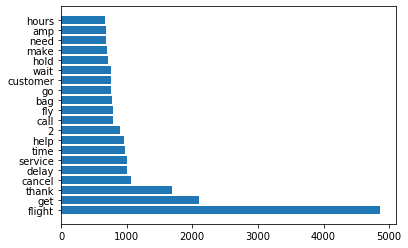

In [35]:
tweet['processed_tweet_tokenize']=tweet.processed_tweet_lem.apply(lambda x: word_tokenize(x.lower()))
fdist = tweet.processed_tweet_tokenize.values
dist=FreqDist(word.lower() for l in list(fdist) for word in l)
plt.barh(*zip(*dist.most_common(n=20)))
plt.show()

In [36]:
tweet.head()

airline_sentiment         airline  \
0           neutral  Virgin America   
1          positive  Virgin America   
2           neutral  Virgin America   
3          negative  Virgin America   
4          negative  Virgin America   

                                                text  sentiment  \
0                @VirginAmerica What @dhepburn said.          0   
1  @VirginAmerica plus you've added commercials t...          1   
2  @VirginAmerica I didn't today... Must mean I n...          0   
3  @VirginAmerica it's really aggressive to blast...         -1   
4  @VirginAmerica and it's a really big bad thing...         -1   

                                         clean_tweet  \
0                                          What said   
1  plus you ve added commercials to the experienc...   
2  I didn t today Must mean I need to take anothe...   
3  it s really aggressive to blast obnoxious ente...   
4           and it s a really big bad thing about it   

                                     processed_tweet  \
0                                               said   
1            plus added commercials experience tacky   
2             today must mean need take another trip   
3  really aggressive blast obnoxious entertainmen...   
4                               really big bad thing   

                                 processed_tweet_lem  \
0                                                say   
1              plus add commercials experience tacky   
2             today must mean need take another trip   
3  really aggressive blast obnoxious entertainmen...   
4                               really big bad thing   

                            processed_tweet_tokenize  
0                                              [say]  
1        [plus, add, commercials, experience, tacky]  
2     [today, must, mean, need, take, another, trip]  
3  [really, aggressive, blast, obnoxious, enterta...  
4                          [really, big, bad, thing]

# Splitting Data set

In [37]:
# tweet = tweet.sample(frac=1).groupby('sentiment', sort=False).head(2363)

In [38]:
X = tweet['processed_tweet_lem']
Y = tweet['sentiment']

In [39]:
X

0                                                      say
1                    plus add commercials experience tacky
2                   today must mean need take another trip
3        really aggressive blast obnoxious entertainmen...
4                                     really big bad thing
                               ...                        
14635                   thank get different flight chicago
14636    leave 20 minutes late flight warn communicatio...
14637          please bring american airlines blackberry10
14638    money change flight answer phone suggestions m...
14639    8 ppl need 2 know many seat next flight plz pu...
Name: processed_tweet_lem, Length: 14640, dtype: object

In [40]:
Y

0        0
1        1
2        0
3       -1
4       -1
        ..
14635    1
14636   -1
14637    0
14638   -1
14639    0
Name: sentiment, Length: 14640, dtype: int64

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

In [42]:
X_train.shape

(11712,)

In [43]:
X_test.shape

(2928,)

In [44]:
y_train.shape

(11712,)

In [45]:
y_test.shape

(2928,)

# Model Training

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
import lightgbm as LGBM
from sklearn.linear_model import LogisticRegression
para={'vect__ngram_range': [(1,1),(1,2)],
     'tfidf__norm': ['l1','l2'],
     'tfidf__use_idf': [True,False],
     'svm__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],}

In [47]:
svm = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                         ('svm', SGDClassifier(loss='hinge', alpha=1e-3, random_state=42)),])
svm_gs = GridSearchCV(svm, param_grid=para, n_jobs=-1, cv=5)
svm_gs.fit(X_train, y_train);
print('best_parameters: ',svm_gs.best_params_)
print("SVM train:\n",metrics.classification_report(y_train, svm_gs.predict(X_train)))
y_predicted = svm_gs.predict(X_test)
print("SVM test:\n",metrics.classification_report(y_test,svm_gs.predict(X_test)))
print(metrics.confusion_matrix(y_test,y_predicted))

best_parameters:  {'svm__alpha': 0.0001, 'tfidf__norm': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}
SVM train:
               precision    recall  f1-score   support

          -1       0.95      0.99      0.97      7344
           0       0.97      0.85      0.91      2471
           1       0.97      0.94      0.95      1897

    accuracy                           0.95     11712
   macro avg       0.96      0.93      0.94     11712
weighted avg       0.96      0.95      0.95     11712

SVM test:
               precision    recall  f1-score   support

          -1       0.80      0.93      0.86      1834
           0       0.68      0.37      0.48       628
           1       0.72      0.67      0.69       466

    accuracy                           0.77      2928
   macro avg       0.73      0.66      0.68      2928
weighted avg       0.76      0.77      0.75      2928

[[1713   70   51]
 [ 323  234   71]
 [ 112   41  313]]


In [48]:
svm = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),('tfidf', TfidfTransformer(norm='l2')),('svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-4, random_state=42)),])
svm_cv = cross_val_score(svm, X_train, y=y_train, n_jobs=-1,cv=5)
print("CV Score for each fold:", svm_cv)
svm.fit(X_train, y_train)
print("SVM train:\n",metrics.classification_report(y_train, svm.predict(X_train)))
y_predited = svm.predict(X_test)
print("SVM test:\n",metrics.classification_report(y_test, y_predited))
print(metrics.confusion_matrix(y_test,y_predited))

CV Score for each fold: [0.79052901 0.78446436 0.77497865 0.78693424 0.78342589]
SVM train:
               precision    recall  f1-score   support

          -1       0.95      0.99      0.97      7344
           0       0.97      0.85      0.91      2471
           1       0.97      0.94      0.95      1897

    accuracy                           0.95     11712
   macro avg       0.96      0.93      0.94     11712
weighted avg       0.96      0.95      0.95     11712

SVM test:
               precision    recall  f1-score   support

          -1       0.80      0.93      0.86      1834
           0       0.68      0.37      0.48       628
           1       0.72      0.67      0.69       466

    accuracy                           0.77      2928
   macro avg       0.73      0.66      0.68      2928
weighted avg       0.76      0.77      0.75      2928

[[1713   70   51]
 [ 323  234   71]
 [ 112   41  313]]


In [49]:
Accuracy=[]
Accuracy.append(metrics.accuracy_score(y_test,y_predited))
Accuracy

[0.7718579234972678]

# Light BGM

In [50]:
clf_lgbm = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                         ('clf-lgbm', LGBM.LGBMClassifier(random_state=13,n_jobs=-1,)),])
lgbm_cv = cross_val_score(clf_lgbm, X_train, y=y_train, n_jobs=-1,cv=5)
print("CV Score for each fold:", lgbm_cv)
clf_lgbm.fit(X_train, y_train)
print("LGBM train:\n",metrics.classification_report(y_train, clf_lgbm.predict(X_train)))
y_predited = clf_lgbm.predict(X_test)
print("LGBM test:\n",metrics.classification_report(y_test,y_predited))
print(metrics.confusion_matrix(y_test,y_predited))

CV Score for each fold: [0.77133106 0.76483141 0.76515798 0.76814688 0.765912  ]
LGBM train:
               precision    recall  f1-score   support

          -1       0.87      0.93      0.90      7344
           0       0.72      0.64      0.68      2471
           1       0.84      0.74      0.79      1897

    accuracy                           0.84     11712
   macro avg       0.81      0.77      0.79     11712
weighted avg       0.83      0.84      0.83     11712

LGBM test:
               precision    recall  f1-score   support

          -1       0.82      0.88      0.85      1834
           0       0.61      0.52      0.56       628
           1       0.69      0.63      0.66       466

    accuracy                           0.77      2928
   macro avg       0.71      0.68      0.69      2928
weighted avg       0.76      0.77      0.76      2928

[[1623  139   72]
 [ 241  325   62]
 [ 106   65  295]]


In [51]:
Accuracy.append(metrics.accuracy_score(y_test,y_predited))
Accuracy

[0.7718579234972678, 0.766051912568306]

# Logistic Regression

In [52]:
clf_LR = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf-LR', LogisticRegression(random_state=42)),])
LR_cv = cross_val_score(clf_LR, X_train, y=y_train, n_jobs=-1,cv=10)
print("CV Score for each fold:", LR_cv)
clf_LR.fit(X_train, y_train)
print("LR train:\n",metrics.classification_report(y_train, clf_LR.predict(X_train)))
y_predicted = clf_LR.predict(X_test)
print("LR test:\n",metrics.classification_report(y_test, y_predicted))
print(metrics.confusion_matrix(y_test,y_predicted))

CV Score for each fold: [0.78601876 0.76791809 0.76365188 0.77559727 0.76686593 0.76857387
 0.76601196 0.78888889 0.77863248 0.76837607]


C:\Users\awali\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\awali\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LR train:
               precision    recall  f1-score   support

          -1       0.83      0.98      0.90      7344
           0       0.86      0.57      0.68      2471
           1       0.90      0.67      0.77      1897

    accuracy                           0.84     11712
   macro avg       0.86      0.74      0.78     11712
weighted avg       0.85      0.84      0.83     11712

LR test:
               precision    recall  f1-score   support

          -1       0.78      0.95      0.86      1834
           0       0.67      0.39      0.49       628
           1       0.78      0.58      0.67       466

    accuracy                           0.77      2928
   macro avg       0.74      0.64      0.67      2928
weighted avg       0.76      0.77      0.75      2928

[[1737   68   29]
 [ 338  242   48]
 [ 145   50  271]]


In [53]:
Accuracy.append(metrics.accuracy_score(y_test,y_predicted))
Accuracy

[0.7718579234972678, 0.766051912568306, 0.7684426229508197]

In [54]:
para={'vect__ngram_range': [(1,1),(1,2)],
     'tfidf__norm': ['l1','l2'],
     'tfidf__use_idf': [True,False],
     'clf-LR__C': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],}

In [55]:
LR_gs = GridSearchCV(clf_LR, param_grid=para, n_jobs=-1, cv=5)
LR_gs.fit(X_train, y_train);
print('best_parameters: ',LR_gs.best_params_)
print("LR train:\n",metrics.classification_report(y_train, LR_gs.predict(X_train)))
y_predicted = LR_gs.predict(X_test)
print("LR test:\n",metrics.classification_report(y_test,LR_gs.predict(X_test)))
print(metrics.confusion_matrix(y_test,y_predicted))

C:\Users\awali\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\awali\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


best_parameters:  {'clf-LR__C': 1.0, 'tfidf__norm': 'l2', 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}
LR train:
               precision    recall  f1-score   support

          -1       0.83      0.96      0.89      7344
           0       0.80      0.54      0.65      2471
           1       0.84      0.66      0.74      1897

    accuracy                           0.83     11712
   macro avg       0.82      0.72      0.76     11712
weighted avg       0.83      0.83      0.82     11712

LR test:
               precision    recall  f1-score   support

          -1       0.80      0.93      0.86      1834
           0       0.66      0.43      0.52       628
           1       0.75      0.61      0.67       466

    accuracy                           0.77      2928
   macro avg       0.74      0.66      0.68      2928
weighted avg       0.76      0.77      0.76      2928

[[1704   87   43]
 [ 306  269   53]
 [ 130   50  286]]


In [56]:
metrics.accuracy_score(y_test,y_predicted)
#Accuracy.append(metrics.accuracy_score(y_test,y_predicted))
#Accuracy

0.7715163934426229

# Naive Bayes

In [57]:
mnb = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                         ('mnb', MultinomialNB(alpha=0.75)),])
mnb_cv = cross_val_score(mnb, X_train, y=y_train, n_jobs=-1,cv=3)
print("CV Score for each fold:", mnb_cv)
mnb.fit(X_train, y_train)
print("MNB train:",metrics.classification_report(y_train, mnb.predict(X_train)))
y_predicted = mnb.predict(X_test)
print("MNB test:",metrics.classification_report(y_test, y_predicted))
print(metrics.confusion_matrix(y_test,y_predicted))

CV Score for each fold: [0.69014085 0.68596311 0.69305662]
MNB train:               precision    recall  f1-score   support

          -1       0.74      1.00      0.85      7344
           0       0.90      0.36      0.51      2471
           1       0.95      0.42      0.59      1897

    accuracy                           0.77     11712
   macro avg       0.86      0.59      0.65     11712
weighted avg       0.81      0.77      0.74     11712

MNB test:               precision    recall  f1-score   support

          -1       0.68      0.99      0.81      1834
           0       0.78      0.18      0.29       628
           1       0.87      0.24      0.37       466

    accuracy                           0.70      2928
   macro avg       0.78      0.47      0.49      2928
weighted avg       0.73      0.70      0.63      2928

[[1815   15    4]
 [ 501  114   13]
 [ 338   18  110]]


In [58]:
Accuracy.append(metrics.accuracy_score(y_test,y_predicted))
Accuracy

[0.7718579234972678, 0.766051912568306, 0.7684426229508197, 0.6963797814207651]

# Random Forest

In [59]:
rfc = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                         ('mnb', RandomForestClassifier(n_estimators=200)),])
rfc_cv = cross_val_score(rfc, X_train, y=y_train, n_jobs=-1,cv=5)
print("CV Score for each fold:", rfc_cv)
rfc.fit(X_train, y_train)
print("RFC train:\n",metrics.classification_report(y_train, rfc.predict(X_train)))
print("RFC test:\n",metrics.classification_report(y_test, rfc.predict(X_test)))
print(metrics.confusion_matrix(y_test,rfc.predict(X_test)))

CV Score for each fold: [0.77133106 0.77037985 0.76345004 0.77796755 0.75523281]
RFC train:
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00      7344
           0       0.99      0.99      0.99      2471
           1       0.98      0.99      0.99      1897

    accuracy                           0.99     11712
   macro avg       0.99      0.99      0.99     11712
weighted avg       0.99      0.99      0.99     11712

RFC test:
               precision    recall  f1-score   support

          -1       0.78      0.92      0.85      1834
           0       0.64      0.42      0.51       628
           1       0.71      0.55      0.62       466

    accuracy                           0.76      2928
   macro avg       0.71      0.63      0.66      2928
weighted avg       0.74      0.76      0.74      2928

[[1691  103   40]
 [ 301  264   63]
 [ 163   46  257]]


In [60]:
Accuracy.append(metrics.accuracy_score(y_test,rfc.predict(X_test)))
Accuracy

[0.7718579234972678,
 0.766051912568306,
 0.7684426229508197,
 0.6963797814207651,
 0.755464480874317]

# Model Accuracy Comparision

In [61]:
Model=['SVM', 'Light GBM', 'Logistic Regression', 'Multinomial Naive Bayes', 'Random Forest']

Text(0.5, 1.0, 'Accuracies of Models')

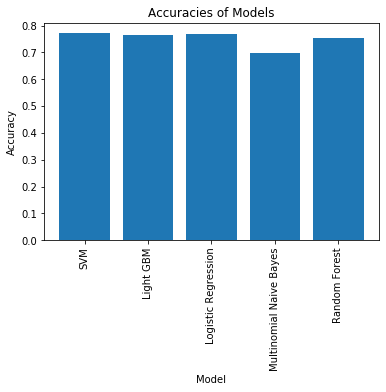

In [62]:
Index = [1,2,3,4,5]
plt.bar(Index,Accuracy)
plt.xticks(Index, Model, rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')

# Hits and Misses

In [63]:
temp = np.argsort(y_test)
temp

1298        0
2886     1764
13754    1763
6784     1760
7793     1758
         ... 
9354      989
8779     2352
121      1359
8327      761
7328     1642
Name: sentiment, Length: 2928, dtype: int64

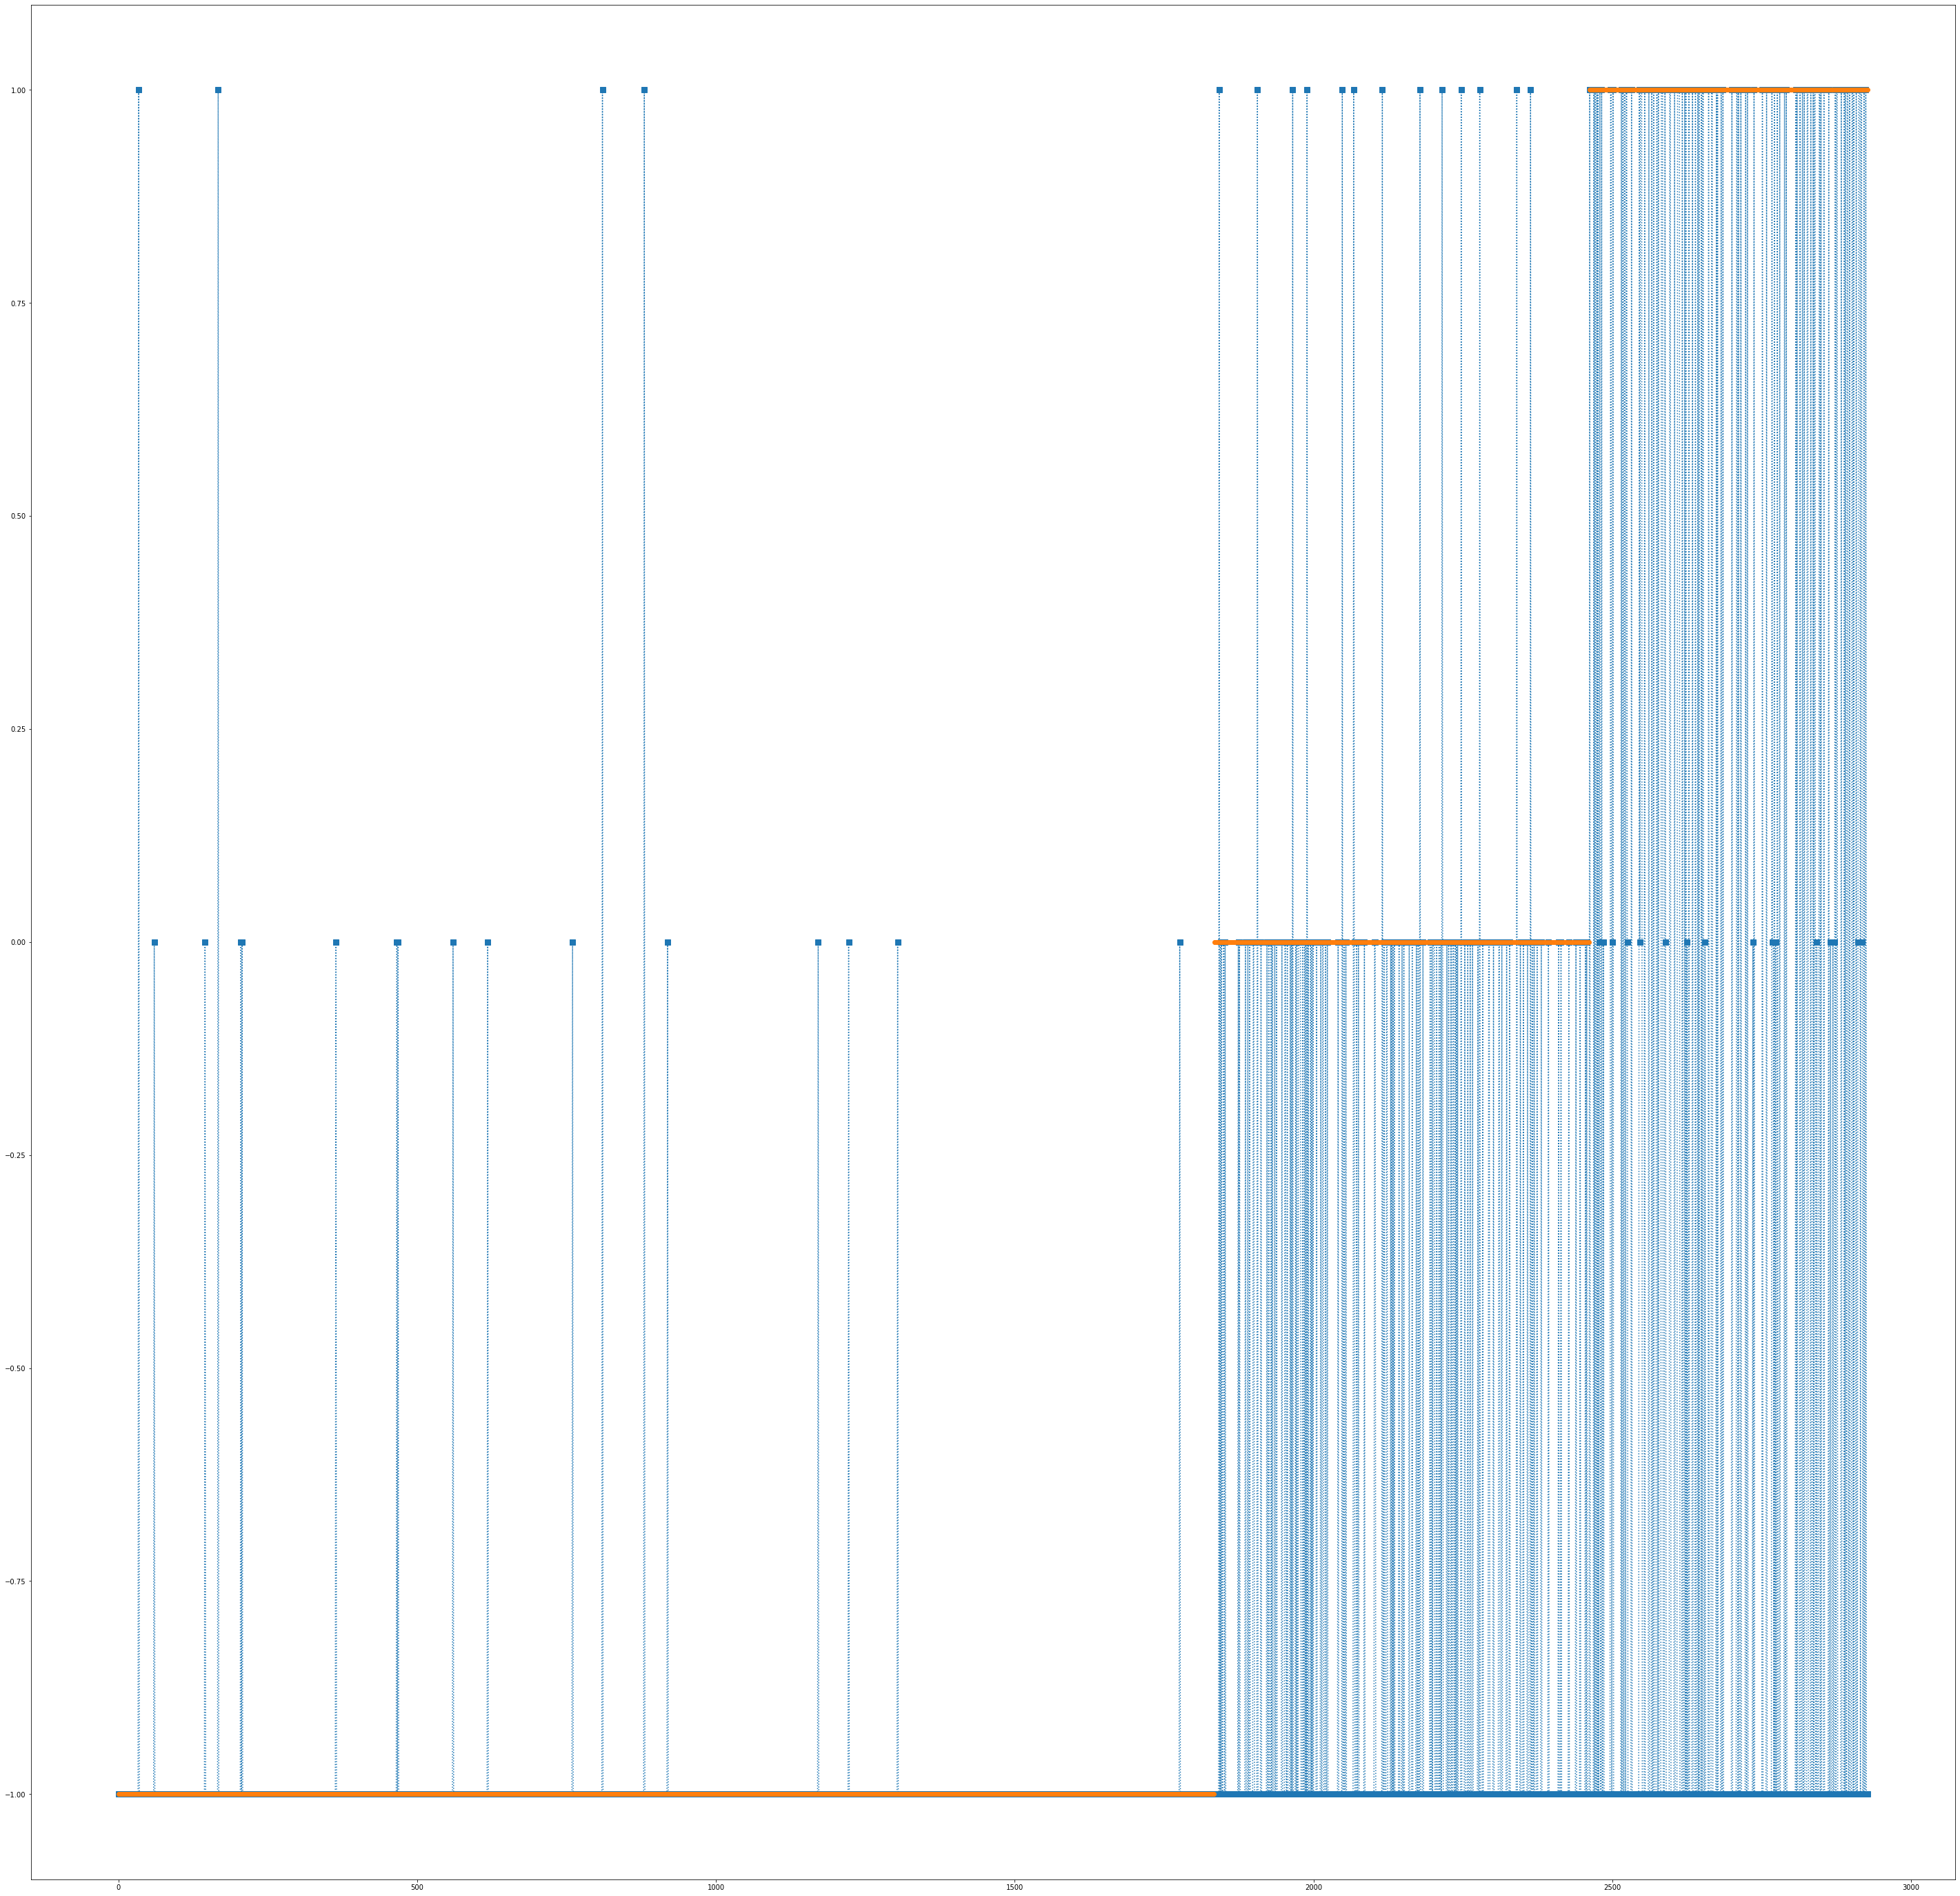

In [64]:
plt.figure(figsize=(50,50))
plt.plot(np.arange(len(y_predicted)), y_predicted[temp], ':s', markersize=8)
plt.plot(np.arange(len(y_predicted)), y_test.iloc[temp], 'o')
plt.show()

In [65]:
y_graph = np.concatenate([y_test[(y_test == -1)].head(10), y_test[(y_test == 0)].head(10), y_test[(y_test == 1)].head(10)])
y_graph

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1], dtype=int64)

In [66]:
temp = np.argsort(y_graph)

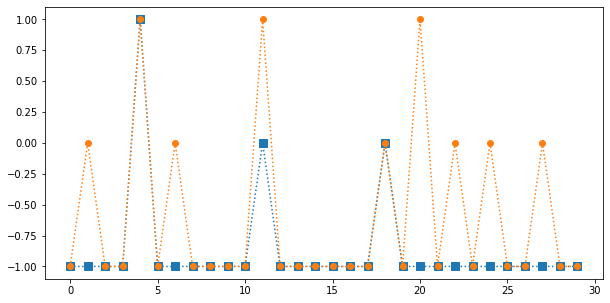

In [67]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(y_graph)), y_predicted[temp], ':s', markersize=8)
plt.plot(np.arange(len(y_graph)), y_test.iloc[temp], ':o')
plt.show()

# Tweet Mining

In [68]:
import tweepy

In [69]:
CONSUMER_KEY    = '2RozKckGnOzNcrtaWu3VXKJSx'
CONSUMER_SECRET = '8l0Pr26BZfTg1ZPsGgyj7CW93SETiLylSTRvbzjI2BEScDALnE'
#CONSUMER_KEY    = '7iWJ6ayUz96PİZdCx9ILDMpsH'
#CONSUMER_SECRET = '7Uto2zs1BocYiHCms599gK5psRe7dMrfJPVJ3axKQ71QbrsbYu'

# Access:
ACCESS_TOKEN  = '1416435420-b7yPVE7YAK5NlwJpOKIouqrk2q94xNY87fnIZ3M'
ACCESS_SECRET = 'M76xd99ZIcuTSwoXJReo8BFqOAKl288oZJbbsQFGvujiC'

def twitter_setup():
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
    api = tweepy.API(auth)
    return api

In [70]:
extractor = twitter_setup()

SouthwestAirData = extractor.user_timeline(screen_name="SouthwestAir", count=100)
print("Number of tweets extracted: {}.\n".format(len(SouthwestAirData)))

Number of tweets extracted: 100.



In [71]:
for singleTweet in SouthwestAirData:
    print(singleTweet.text)

@JohnSCook So sorry for any disappointment onboard, John. While we don't specifically block VPN access, we also don… https://t.co/JAkyDc5QrA
@shannon1014 Welp...there's no beating around the bush. Looks like you're Family now and as a member of this Family… https://t.co/KChTN9Xd22
@Lucyvonne11 This is music to our ears, Lucy! Please DM your flight confirmation number for a sweet surprise. ❤️ -L… https://t.co/qb7b3tWLRK
@joanna72rice Great question, Joanna!  Believe it or not, "Light Sabers" do appear on TSA's list of approved carryo… https://t.co/g9STmGBPLp
@alwayspursue Sorry that you aren’t seeing your desired destination in our current fare sale. During every sale, we… https://t.co/KrFBoWHlhf
@teahhanson We appreciate your patience, Teah. On March 12, 2020 we will open our schedule for sale through October… https://t.co/70KNSkqlpI
@hillaryberman We'd be happy to provide a flight status if you'd like, Hillary. Feel free to DM the city pairs and… https://t.co/cYZSzqNea3
@MeganMilholla

In [72]:
SouthwestAirData = pd.DataFrame(data=[tweet.text for tweet in SouthwestAirData], columns=['Tweets'])
SouthwestAirData

Tweets
0   @JohnSCook So sorry for any disappointment onb...
1   @shannon1014 Welp...there's no beating around ...
2   @Lucyvonne11 This is music to our ears, Lucy! ...
3   @joanna72rice Great question, Joanna!  Believe...
4   @alwayspursue Sorry that you aren’t seeing you...
..                                                ...
95  @lesterhead We are so happy to have you onboar...
96  @plssendsmhelp We are glad to have you on boar...
97  @HighlyValued Thanks for that information, Che...
98  @BlondeFittie25 Happy to have you onboard. Let...
99  @rhymepartners Just trying to get you the assi...

[100 rows x 1 columns]

In [73]:
SouthwestAirData['clean_tweet']=SouthwestAirData['Tweets'].apply(lambda x: clean_tweet(x))
SouthwestAirData

Tweets  \
0   @JohnSCook So sorry for any disappointment onb...   
1   @shannon1014 Welp...there's no beating around ...   
2   @Lucyvonne11 This is music to our ears, Lucy! ...   
3   @joanna72rice Great question, Joanna!  Believe...   
4   @alwayspursue Sorry that you aren’t seeing you...   
..                                                ...   
95  @lesterhead We are so happy to have you onboar...   
96  @plssendsmhelp We are glad to have you on boar...   
97  @HighlyValued Thanks for that information, Che...   
98  @BlondeFittie25 Happy to have you onboard. Let...   
99  @rhymepartners Just trying to get you the assi...   

                                          clean_tweet  
0   So sorry for any disappointment onboard John W...  
1   Welp there s no beating around the bush Looks ...  
2   This is music to our ears Lucy Please DM your ...  
3   Great question Joanna Believe it or not Light ...  
4   Sorry that you aren t seeing your desired dest...  
..                                                ...  
95  We are so happy to have you onboard If you sen...  
96  We are glad to have you on board and we look f...  
97  Thanks for that information Chelsiee It looks ...  
98  Happy to have you onboard Let s make your firs...  
99  Just trying to get you the assistance you need...  

[100 rows x 2 columns]

In [74]:
SouthwestAirData['processed_tweet_lem']=SouthwestAirData['clean_tweet'].apply(lambda x: word_lemmatizer(x))
SouthwestAirData

Tweets  \
0   @JohnSCook So sorry for any disappointment onb...   
1   @shannon1014 Welp...there's no beating around ...   
2   @Lucyvonne11 This is music to our ears, Lucy! ...   
3   @joanna72rice Great question, Joanna!  Believe...   
4   @alwayspursue Sorry that you aren’t seeing you...   
..                                                ...   
95  @lesterhead We are so happy to have you onboar...   
96  @plssendsmhelp We are glad to have you on boar...   
97  @HighlyValued Thanks for that information, Che...   
98  @BlondeFittie25 Happy to have you onboard. Let...   
99  @rhymepartners Just trying to get you the assi...   

                                          clean_tweet  \
0   So sorry for any disappointment onboard John W...   
1   Welp there s no beating around the bush Looks ...   
2   This is music to our ears Lucy Please DM your ...   
3   Great question Joanna Believe it or not Light ...   
4   Sorry that you aren t seeing your desired dest...   
..                                                ...   
95  We are so happy to have you onboard If you sen...   
96  We are glad to have you on board and we look f...   
97  Thanks for that information Chelsiee It looks ...   
98  Happy to have you onboard Let s make your firs...   
99  Just trying to get you the assistance you need...   

                                  processed_tweet_lem  
0   So sorry for any disappointment onboard John W...  
1   Welp there s no beat around the bush Looks lik...  
2   This be music to our ears Lucy Please DM your ...  
3   Great question Joanna Believe it or not Light ...  
4   Sorry that you aren t see your desire destinat...  
..                                                ...  
95  We be so happy to have you onboard If you send...  
96  We be glad to have you on board and we look fo...  
97  Thanks for that information Chelsiee It look l...  
98  Happy to have you onboard Let s make your firs...  
99  Just try to get you the assistance you need Me...  

[100 rows x 3 columns]

In [75]:
SouthwestAirData['sentiment']=clf_LR.predict(SouthwestAirData['processed_tweet_lem'])
SouthwestAirData

Tweets  \
0   @JohnSCook So sorry for any disappointment onb...   
1   @shannon1014 Welp...there's no beating around ...   
2   @Lucyvonne11 This is music to our ears, Lucy! ...   
3   @joanna72rice Great question, Joanna!  Believe...   
4   @alwayspursue Sorry that you aren’t seeing you...   
..                                                ...   
95  @lesterhead We are so happy to have you onboar...   
96  @plssendsmhelp We are glad to have you on boar...   
97  @HighlyValued Thanks for that information, Che...   
98  @BlondeFittie25 Happy to have you onboard. Let...   
99  @rhymepartners Just trying to get you the assi...   

                                          clean_tweet  \
0   So sorry for any disappointment onboard John W...   
1   Welp there s no beating around the bush Looks ...   
2   This is music to our ears Lucy Please DM your ...   
3   Great question Joanna Believe it or not Light ...   
4   Sorry that you aren t seeing your desired dest...   
..                                                ...   
95  We are so happy to have you onboard If you sen...   
96  We are glad to have you on board and we look f...   
97  Thanks for that information Chelsiee It looks ...   
98  Happy to have you onboard Let s make your firs...   
99  Just trying to get you the assistance you need...   

                                  processed_tweet_lem  sentiment  
0   So sorry for any disappointment onboard John W...         -1  
1   Welp there s no beat around the bush Looks lik...         -1  
2   This be music to our ears Lucy Please DM your ...          0  
3   Great question Joanna Believe it or not Light ...          0  
4   Sorry that you aren t see your desire destinat...         -1  
..                                                ...        ...  
95  We be so happy to have you onboard If you send...          1  
96  We be glad to have you on board and we look fo...          1  
97  Thanks for that information Chelsiee It look l...          0  
98  Happy to have you onboard Let s make your firs...         -1  
99  Just try to get you the assistance you need Me...         -1  

[100 rows x 4 columns]

Text(0.5, 1.0, 'Count of Sentiment')

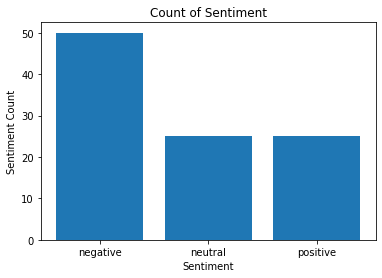

In [76]:
Sentiment_count=SouthwestAirData['sentiment'].value_counts()
Sentiment_count
Index = [1,2,3]
plt.bar(Index,Sentiment_count)
plt.xticks(Index,['negative','neutral','positive'])
plt.ylabel('Sentiment Count')
plt.xlabel('Sentiment')
plt.title('Count of Sentiment')

In [77]:
AmericanAirData = extractor.user_timeline(screen_name="AmericanAir", count=100)
print("Number of tweets extracted: {}.\n".format(len(AmericanAirData)))

Number of tweets extracted: 100.



In [78]:
for singleTweet in AmericanAirData:
    print(singleTweet.text)

@DeniseMCarlin We see your DM and we'll follow up with you there shortly.
@brianthemerg This isn't the record we're going for and truly sorry. We'll have you wheels up soon.
@bolli921 We're aiming for a 1:20p departure. We'll update you with any changes. If you need rebooking help, just let us know.
@Beau_Nerjams Please provide your flight details via with a quick follow.
@ragiacomelli Providing accurate info is important and so sorry that you didn't make it. We see that our team helpe… https://t.co/xEh6H2OMRS
@edtech_dorsey Debra and Trish are amazing! Thanks so much for the shout-out. #AATeam
@marielmendozae Thanks so much for the shout-out to Roger and crew! #AATeam
@CorporalRicci Upgrades are very popular, especially overseas. You can always be added to the upgrade waitlist.
@harropj Please let a crewmember know about the window.They have a few tricks up their sleeve.
@DonaldCClarkJr The ground team works hard to get everyone's bags out as quickly as  possible. Our apologies for th

In [79]:
AmericanAirData = pd.DataFrame(data=[tweet.text for tweet in AmericanAirData], columns=['Tweets'])
AmericanAirData['clean_tweet']=AmericanAirData['Tweets'].apply(lambda x: clean_tweet(x))
AmericanAirData['processed_tweet_lem']=AmericanAirData['clean_tweet'].apply(lambda x: word_lemmatizer(x))
AmericanAirData['sentiment']=clf_LR.predict(AmericanAirData['processed_tweet_lem'])
AmericanAirData

Tweets  \
0   @DeniseMCarlin We see your DM and we'll follow...   
1   @brianthemerg This isn't the record we're goin...   
2   @bolli921 We're aiming for a 1:20p departure. ...   
3   @Beau_Nerjams Please provide your flight detai...   
4   @ragiacomelli Providing accurate info is impor...   
..                                                ...   
95  @ZebLongNC We're so sorry about the added trav...   
96  @Skylar01 We're truly sorry this happened and ...   
97  @_paulinalauren We expect all employees to be ...   
98  @MelissaBestLife We're happy to review your tr...   
99  @barrientosmusic It should take maximum 24 hou...   

                                          clean_tweet  \
0   We see your DM and we ll follow up with you th...   
1   This isn t the record we re going for and trul...   
2   We re aiming for a 1 20p departure We ll updat...   
3   Nerjams Please provide your flight details via...   
4   Providing accurate info is important and so so...   
..                                                ...   
95  We re so sorry about the added travel time Thi...   
96  We re truly sorry this happened and will pass ...   
97  paulinalauren We expect all employees to be co...   
98  We re happy to review your trip Please DM your...   
99  It should take maximum 24 hours Please give us...   

                                  processed_tweet_lem  sentiment  
0   We see your DM and we ll follow up with you th...          0  
1   This isn t the record we re go for and truly s...         -1  
2   We re aim for a 1 20p departure We ll update y...         -1  
3   Nerjams Please provide your flight detail via ...          0  
4   Providing accurate info be important and so so...         -1  
..                                                ...        ...  
95  We re so sorry about the add travel time This ...         -1  
96  We re truly sorry this happen and will pass it...          0  
97  paulinalauren We expect all employees to be co...         -1  
98  We re happy to review your trip Please DM your...          0  
99  It should take maximum 24 hours Please give us...         -1  

[100 rows x 4 columns]

Text(0.5, 1.0, 'Count of Sentiment')

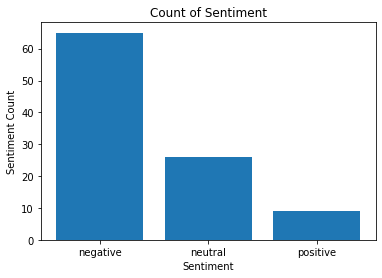

In [80]:
Sentiment_count=AmericanAirData['sentiment'].value_counts()
Sentiment_count
Index = [1,2,3]
plt.bar(Index,Sentiment_count)
plt.xticks(Index,['negative','neutral','positive'])
plt.ylabel('Sentiment Count')
plt.xlabel('Sentiment')
plt.title('Count of Sentiment')

# Pakistan Airline Data 

In [81]:
PIAData = extractor.user_timeline(screen_name="Official_PIA", count=100)
print("Number of tweets extracted: {}.\n".format(len(PIAData)))

Number of tweets extracted: 99.



In [83]:
for singleTweet in PIAData:
    print(singleTweet.text)

RT @AbdulqadirARY: دوران پرواز طیارے میں رہ جانے والا میرا پرس مجھے واپس مل گیا! شکریہ @Official_PIA https://t.co/WlfAhJ8GwK
RT @AbdulqadirARY: @ghafari365 @Official_PIA جی ہاں پوری رقم صحیح سلامت مل گئی! دیکھئے یہ ویڈیو👇
https://t.co/fITlw6oWtT
Eat like a local in Copenhagen, and relish Danish delicacies from Pastries and more! PIA is taking you to the Danis… https://t.co/FlvBFcKJOU
Europe trippin' is on! Take a trip to Barcelona for the ultimate beach holiday with PIA. Book online at… https://t.co/cKgct3wfRA
Love is in the air, so treat your special someone with a trip to Paris - the city of love! That too with PIA! Paris… https://t.co/KAsfPeamBg
Travel from Pakistan to London from 1st Feb till 15th March 2020 and avail an amazing 10% off! Booking till 29th Fe… https://t.co/Bf4v3e4Pqu
Experience the style hub of Italy, the most important fashion centers of the world - Milan! Travel in style with PI… https://t.co/csJX4MEx9G
No better way to tour the mesmerizing city of Copenhagen than

In [84]:
PIAData = pd.DataFrame(data=[tweet.text for tweet in PIAData], columns=['Tweets'])
PIAData['clean_tweet']=PIAData['Tweets'].apply(lambda x: clean_tweet(x))
PIAData['processed_tweet_lem']=PIAData['clean_tweet'].apply(lambda x: word_lemmatizer(x))
PIAData['sentiment']=clf_LR.predict(PIAData['processed_tweet_lem'])
PIAData

Tweets  \
0   RT @AbdulqadirARY: دوران پرواز طیارے میں رہ جا...   
1   RT @AbdulqadirARY: @ghafari365 @Official_PIA ج...   
2   Eat like a local in Copenhagen, and relish Dan...   
3   Europe trippin' is on! Take a trip to Barcelon...   
4   Love is in the air, so treat your special some...   
..                                                ...   
94              @drfaiziii Its work in progress Faizi   
95  No need to travel light! Bringing you an upgra...   
96  New Year Sale! Travel from Canada to Pakistan ...   
97  Pakistan has been declared as the world’s 3rd ...   
98  Catch the match! #PIA #PIATrivia #PIAPlay http...   

                                          clean_tweet  \
0                                              RT PIA   
1                                              RT PIA   
2   Eat like a local in Copenhagen and relish Dani...   
3   Europe trippin is on Take a trip to Barcelona ...   
4   Love is in the air so treat your special someo...   
..                                                ...   
94                         Its work in progress Faizi   
95  No need to travel light Bringing you an upgrad...   
96  New Year Sale Travel from Canada to Pakistan f...   
97  Pakistan has been declared as the world s 3rd ...   
98              Catch the match PIA PIATrivia PIAPlay   

                                  processed_tweet_lem  sentiment  
0                                              RT PIA         -1  
1                                              RT PIA         -1  
2   Eat like a local in Copenhagen and relish Dani...         -1  
3   Europe trippin be on Take a trip to Barcelona ...          0  
4   Love be in the air so treat your special someo...          1  
..                                                ...        ...  
94                         Its work in progress Faizi         -1  
95  No need to travel light Bringing you an upgrad...          0  
96  New Year Sale Travel from Canada to Pakistan f...          0  
97  Pakistan have be declare as the world s 3rd hi...         -1  
98              Catch the match PIA PIATrivia PIAPlay         -1  

[99 rows x 4 columns]

In [92]:
PIAData.head(20)

Tweets  \
0   RT @AbdulqadirARY: دوران پرواز طیارے میں رہ جا...   
1   RT @AbdulqadirARY: @ghafari365 @Official_PIA ج...   
2   Eat like a local in Copenhagen, and relish Dan...   
3   Europe trippin' is on! Take a trip to Barcelon...   
4   Love is in the air, so treat your special some...   
5   Travel from Pakistan to London from 1st Feb ti...   
6   Experience the style hub of Italy, the most im...   
7   No better way to tour the mesmerizing city of ...   
8   From green spaces, panoramic views to vintage ...   
9   Travel from Pakistan to London from 1st Feb ti...   
10  Paris is not just the city of love &amp; roman...   
11  Visit the mesmerizing metropolis - Milan! This...   
12  @FahmidaIqbal @pid_gov The handle was lifted a...   
13  @dailytimespak The handle was lifted accidentl...   
14  @naeemqureshi86 @mophrd @sayedzbukhari Always ...   
15  @cheenaagha The handle was lifted accidently b...   
16  @gulftoday The handle was lifted accidently by...   
17  @hypebaji The handle was lifted accidently by ...   
18  RT @ukinpakistan: 🇬🇧 @transportgovuk &amp; @uk...   
19  “Without the professionalism of PIA and it’s s...   

                                          clean_tweet  \
0                                              RT PIA   
1                                              RT PIA   
2   Eat like a local in Copenhagen and relish Dani...   
3   Europe trippin is on Take a trip to Barcelona ...   
4   Love is in the air so treat your special someo...   
5   Travel from Pakistan to London from 1st Feb ti...   
6   Experience the style hub of Italy the most imp...   
7   No better way to tour the mesmerizing city of ...   
8   From green spaces panoramic views to vintage m...   
9   Travel from Pakistan to London from 1st Feb ti...   
10  Paris is not just the city of love amp romance...   
11  Visit the mesmerizing metropolis Milan This fa...   
12  gov The handle was lifted accidently by one of...   
13  The handle was lifted accidently by one of the...   
14                               Always happy to help   
15  The handle was lifted accidently by one of the...   
16  The handle was lifted accidently by one of the...   
17  The handle was lifted accidently by one of the...   
18  RT amp were hosted by PIA pcaa amp Airport Sec...   
19  Without the professionalism of PIA and it s st...   

                                  processed_tweet_lem  sentiment  
0                                              RT PIA         -1  
1                                              RT PIA         -1  
2   Eat like a local in Copenhagen and relish Dani...         -1  
3   Europe trippin be on Take a trip to Barcelona ...          0  
4   Love be in the air so treat your special someo...          1  
5   Travel from Pakistan to London from 1st Feb ti...          0  
6   Experience the style hub of Italy the most imp...         -1  
7   No better way to tour the mesmerize city of Co...         -1  
8   From green space panoramic view to vintage mus...         -1  
9   Travel from Pakistan to London from 1st Feb ti...          0  
10  Paris be not just the city of love amp romance...          1  
11  Visit the mesmerize metropolis Milan This fash...         -1  
12  gov The handle be lift accidently by one of th...         -1  
13  The handle be lift accidently by one of the pa...         -1  
14                               Always happy to help          1  
15  The handle be lift accidently by one of the pa...         -1  
16  The handle be lift accidently by one of the pa...         -1  
17  The handle be lift accidently by one of the pa...         -1  
18  RT amp be host by PIA pcaa amp Airport Securit...         -1  
19  Without the professionalism of PIA and it s st...         -1

Text(0.5, 1.0, 'Count of Sentiment')

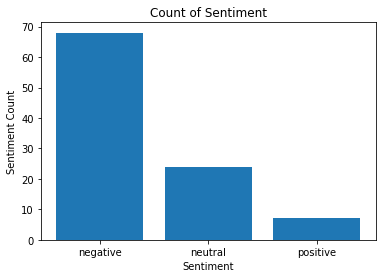

In [89]:
Sentiment_count=PIAData['sentiment'].value_counts()
Sentiment_count
Index = [1,2,3]
plt.bar(Index,Sentiment_count)
plt.xticks(Index,['negative','neutral','positive'])
plt.ylabel('Sentiment Count')
plt.xlabel('Sentiment')
plt.title('Count of Sentiment')

In [91]:
PIAData[PIAData.sentiment == 1]

Tweets  \
4   Love is in the air, so treat your special some...   
10  Paris is not just the city of love &amp; roman...   
14  @naeemqureshi86 @mophrd @sayedzbukhari Always ...   
32  PIA observed Kashmir Solidarity Day with great...   
42                       @UtkarshThakkar Thank you :)   
47          @usmanghani110 @mafsid Thank you Usman :)   
69          @saamirhassan Thank you for your feedback   

                                          clean_tweet  \
4   Love is in the air so treat your special someo...   
10  Paris is not just the city of love amp romance...   
14                               Always happy to help   
32  PIA observed Kashmir Solidarity Day with great...   
42                                          Thank you   
47                                    Thank you Usman   
69                        Thank you for your feedback   

                                  processed_tweet_lem  sentiment  
4   Love be in the air so treat your special someo...          1  
10  Paris be not just the city of love amp romance...          1  
14                               Always happy to help          1  
32  PIA observe Kashmir Solidarity Day with great ...          1  
42                                          Thank you          1  
47                                    Thank you Usman          1  
69                        Thank you for your feedback          1

# Testing on Text

In [177]:
my_tweets = pd.Series(["@AmericanAir kicked me off a flight after I sat down involuntarily because they had oversold the flight and were at weight capacity. When I got to the agent to get voucher they said because I didn’t volunteer to get off I didn’t get one. Never flew #AmericanAir again #Poorservice"
                      ,"@UnitedAirways Awesome flight. Amazed with the staff service. #acceptable @Delta @richardbranson"
                      ,"@VirginAmerica this morning I was forced to repack a suitcase w a medical device because it was barely overweight - wasn't even given an option to pay extra. My spouses suitcase then burst at the seam with the added device and had to be taped shut. Awful experience so far!"
                      ,"Board airplane home. Computer issue. Get off plane, traverse airport to gate on opp side. Get on new plane hour later. Plane too heavy. 8 volunteers get off plane. Ohhh the adventure of travel ✈️ @VirginAmerica"
                      ,"@Delta Flight was just Ok."])


In [178]:
myTweetsData = pd.DataFrame(data=my_tweets, columns=['Tweets'])
myTweetsData

Tweets
0  @AmericanAir kicked me off a flight after I sa...
1  @UnitedAirways Awesome flight. Amazed with the...
2  @VirginAmerica this morning I was forced to re...
3  Board airplane home. Computer issue. Get off p...
4                         @Delta Flight was just Ok.

In [179]:
myTweetsData['clean_tweet']=myTweetsData['Tweets'].apply(lambda x: clean_tweet(x))
myTweetsData['processed_tweet_lem']=myTweetsData['clean_tweet'].apply(lambda x: word_lemmatizer(x))
myTweetsData['sentiment']=clf_LR.predict(myTweetsData['processed_tweet_lem'])
myTweetsData

Tweets  \
0  @AmericanAir kicked me off a flight after I sa...   
1  @UnitedAirways Awesome flight. Amazed with the...   
2  @VirginAmerica this morning I was forced to re...   
3  Board airplane home. Computer issue. Get off p...   
4                         @Delta Flight was just Ok.   

                                         clean_tweet  \
0  kicked me off a flight after I sat down involu...   
1  Awesome flight Amazed with the staff service a...   
2  this morning I was forced to repack a suitcase...   
3  Board airplane home Computer issue Get off pla...   
4                                 Flight was just Ok   

                                 processed_tweet_lem  sentiment  
0  kick me off a flight after I sit down involunt...         -1  
1  Awesome flight Amazed with the staff service a...          1  
2  this morning I be force to repack a suitcase w...         -1  
3  Board airplane home Computer issue Get off pla...         -1  
4                                  Flight be just Ok          0

# Dump Training Model

In [93]:
import pickle

In [94]:
filename = 'finalized_model.sav'
pickle.dump(clf_LR, open(filename, 'wb'))

# Word Cloud

In [180]:
words = ' '.join(tweet['processed_tweet'])
cleaned_word = " ".join(word for word in words.split())
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

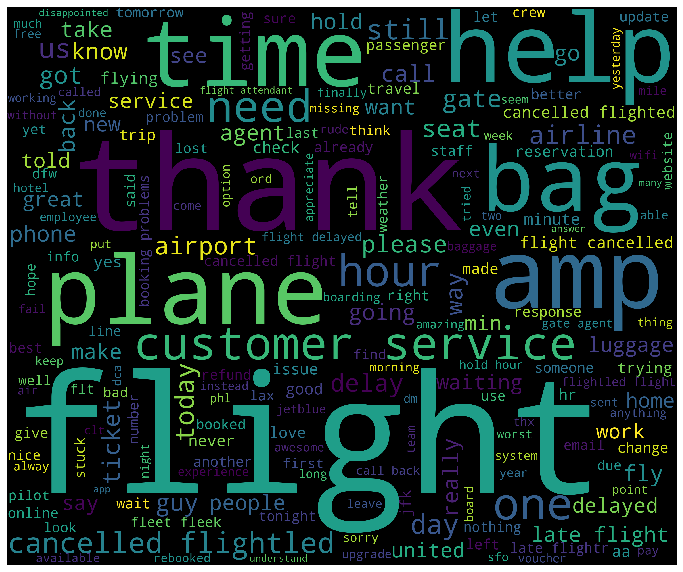

In [181]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [182]:
df=tweet[tweet['airline_sentiment']=='positive']
words = ' '.join(df['processed_tweet'])
cleaned_word = " ".join(word for word in words.split())
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

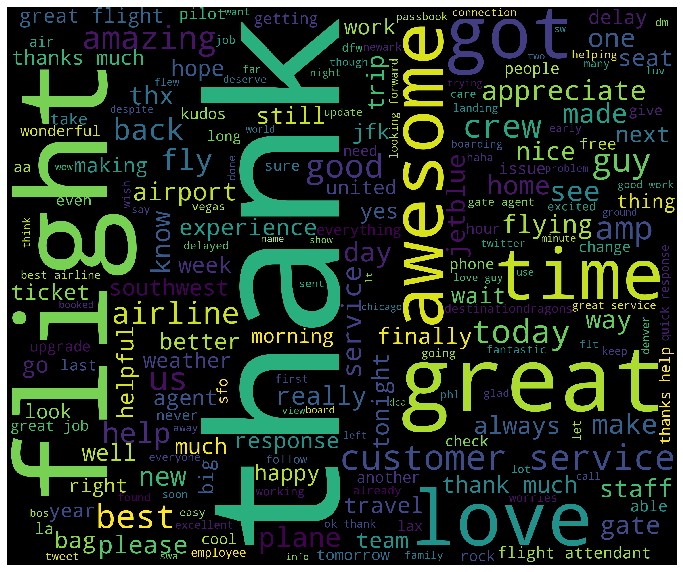

In [183]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [184]:
df=tweet[tweet['airline_sentiment']=='negative']
words = ' '.join(df['processed_tweet'])
cleaned_word = " ".join(word for word in words.split())
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

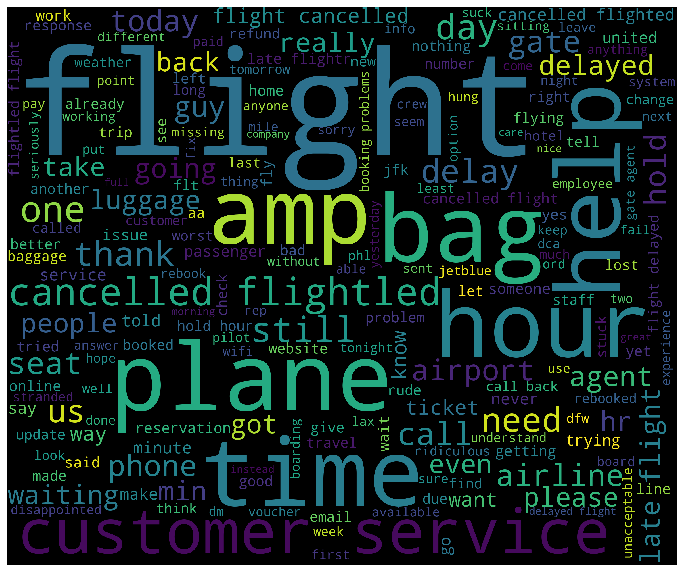

In [185]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [186]:
df=tweet[tweet['airline_sentiment']=='neutral']
words = ' '.join(df['processed_tweet'])
cleaned_word = " ".join(word for word in words.split())
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

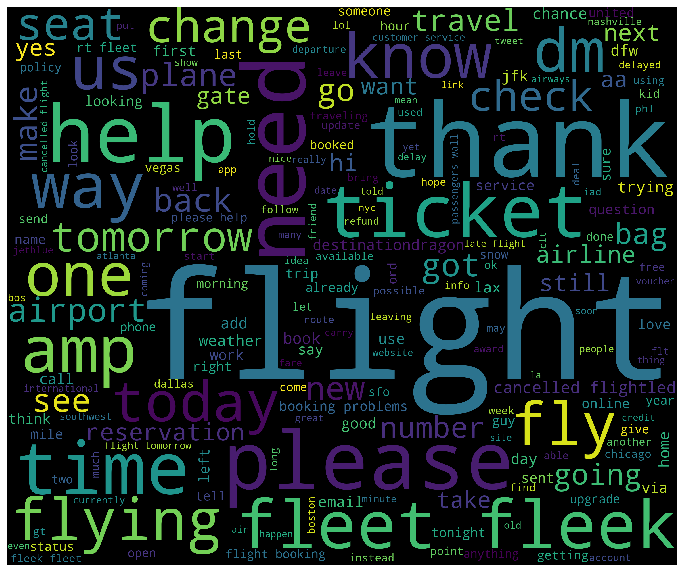

In [187]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()